In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/1_pt"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



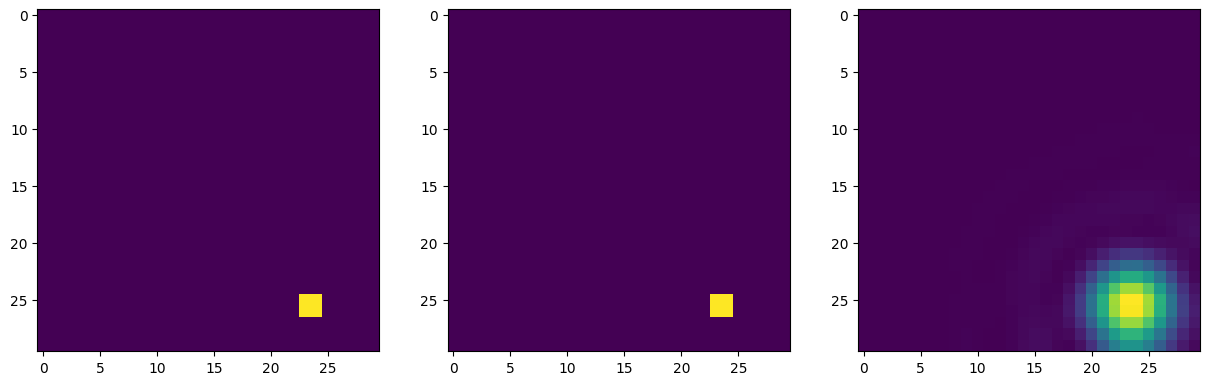

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

with open(FOLDER + '/sourcePts.pkl', 'wb') as file: 
    pickle.dump(sourcePts, file)

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


4


"\nfor k in sourcePts:\n    plt.scatter(k[1],k[0],c='r')\nplt.imshow(mask)\n"

In [5]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            if not (x+i >= 0 and x+i < len(img) and y+j >= 0 and y+j < len(img[0])):
                total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

outputIntensity = {}
(outputWidth, outputHeight) = out.shape

for pt in sourcePts:
    x = pt[0]
    y = pt[1]
    outputIntensity[(x,y)] = AverageFilter(out,x,y)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Add a bunch of random points
for i in range(outputWidth*outputHeight//2):
    x = random.randint(0,maskWidth-1)
    y = random.randint(0,maskHeight-1)
    if mask[x,y] == 0:
        continue
    distance = [euclideanDistance(sourcePts[k],(x,y))/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,x,y)/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.])]


In [8]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

In [9]:
class Net(nn.Module):
    def __init__(self,N,output_intensity=None):
        super(Net, self).__init__()
        self.polynomial_degree = 4
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        #self.polynomial_weights.weight.data[0][0] = -300
        self.actual_intensity = nn.Linear(N,1,bias=False)
        if output_intensity is not None:
            for i in range(N):
                self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x


In [10]:
model = Net(N,intensityMatrix.data.flatten())
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
#criterion = nn.MSELoss()
criterion = nn.HuberLoss(delta=0.1)
optimizer = optim.SGD([
                    {'params': model.polynomial_weights.parameters(), 'lr': 0.01},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)
for parameter in model.actual_intensity.parameters():
    parameter.requires_grad = False

In [11]:
#Training loop

EPOCH = 200
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"


for epoch in range(EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Epoch: ",epoch+1, " Loss: ",running_loss)

for parameter in model.actual_intensity.parameters():
    parameter.requires_grad = True

for epoch in range(EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Epoch: ",epoch+1, " Loss: ",running_loss)
    
print('Finished Training')

loss = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'N': N,
            }, PATH)


Epoch:  1  Loss:  0.0
Epoch:  2  Loss:  0.0
Epoch:  3  Loss:  0.0


Epoch:  4  Loss:  0.0
Epoch:  5  Loss:  0.0
Epoch:  6  Loss:  0.0
Epoch:  7  Loss:  0.0
Epoch:  8  Loss:  0.0
Epoch:  9  Loss:  0.0
Epoch:  10  Loss:  0.0
Epoch:  11  Loss:  0.0
Epoch:  12  Loss:  0.0
Epoch:  13  Loss:  0.0
Epoch:  14  Loss:  0.0
Epoch:  15  Loss:  0.0
Epoch:  16  Loss:  0.0
Epoch:  17  Loss:  0.0
Epoch:  18  Loss:  0.0
Epoch:  19  Loss:  0.0
Epoch:  20  Loss:  0.0
Epoch:  21  Loss:  0.0
Epoch:  22  Loss:  0.0
Epoch:  23  Loss:  0.0
Epoch:  24  Loss:  0.0
Epoch:  25  Loss:  0.0
Epoch:  26  Loss:  0.0
Epoch:  27  Loss:  0.0
Epoch:  28  Loss:  0.0
Epoch:  29  Loss:  0.0
Epoch:  30  Loss:  0.0
Epoch:  31  Loss:  0.0
Epoch:  32  Loss:  0.0
Epoch:  33  Loss:  0.0
Epoch:  34  Loss:  0.0
Epoch:  35  Loss:  0.0
Epoch:  36  Loss:  0.0
Epoch:  37  Loss:  0.0
Epoch:  38  Loss:  0.0
Epoch:  39  Loss:  0.0
Epoch:  40  Loss:  0.0
Epoch:  41  Loss:  0.0
Epoch:  42  Loss:  0.0
Epoch:  43  Loss:  0.0
Epoch:  44  Loss:  0.0
Epoch:  45  Loss:  0.0
Epoch:  46  Loss:  0.0
Epoch:  47  Loss:

Exception ignored in: <function _releaseLock at 0x7f00dbe9d9d0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch:  166  Loss:  0.0
Epoch:  167  Loss:  0.0
Epoch:  168  Loss:  0.0
Epoch:  169  Loss:  0.0
Epoch:  170  Loss:  0.0
Epoch:  171  Loss:  0.0
Epoch:  172  Loss:  0.0
Epoch:  173  Loss:  0.0
Epoch:  174  Loss:  0.0
Epoch:  175  Loss:  0.0
Epoch:  176  Loss:  0.0
Epoch:  177  Loss:  0.0
Epoch:  178  Loss:  0.0
Epoch:  179  Loss:  0.0
Epoch:  180  Loss:  0.0
Epoch:  181  Loss:  0.0
Epoch:  182  Loss:  0.0
Epoch:  183  Loss:  0.0
Epoch:  184  Loss:  0.0
Epoch:  185  Loss:  0.0
Epoch:  186  Loss:  0.0
Epoch:  187  Loss:  0.0
Epoch:  188  Loss:  0.0
Epoch:  189  Loss:  0.0
Epoch:  190  Loss:  0.0
Epoch:  191  Loss:  0.0
Epoch:  192  Loss:  0.0
Epoch:  193  Loss:  0.0
Epoch:  194  Loss:  0.0
Epoch:  195  Loss:  0.0
Epoch:  196  Loss:  0.0
Epoch:  197  Loss:  0.0
Epoch:  198  Loss:  0.0
Epoch:  199  Loss:  0.0
Epoch:  200  Loss:  0.0
Finished Training


tensor([[0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
         0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
         0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
         0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
         0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
         0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
         0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
         0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
         0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
         0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
         0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
         1.0000]])
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0203e-04, 1.0410e-0

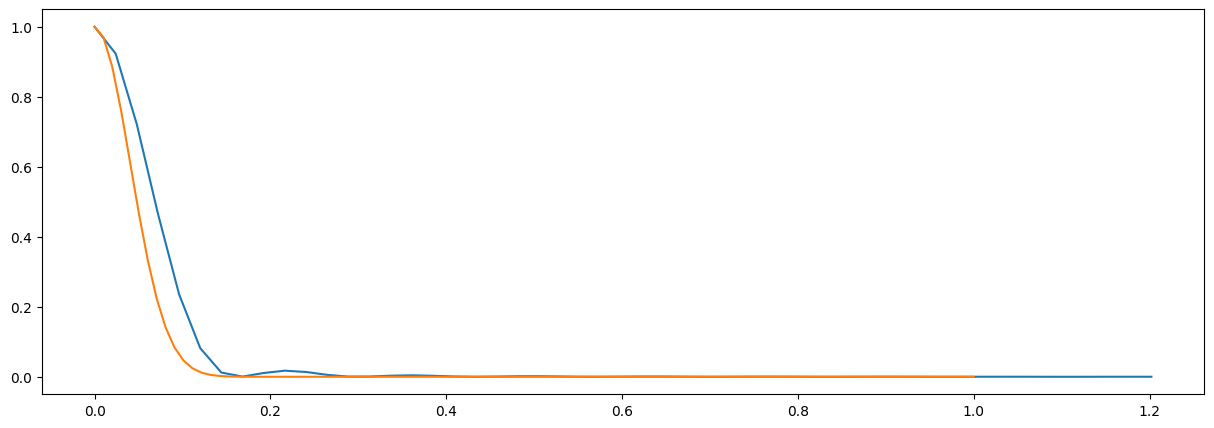

In [ ]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


In [ ]:
print(model.polynomial_weights.weight.data)
print(model.actual_intensity.weight.data)

tensor([[-3.0000e+02,  4.2672e-01, -3.9829e-01,  1.4333e-01]])
tensor([[0.7510, 0.7457, 0.7482, 0.7535]])


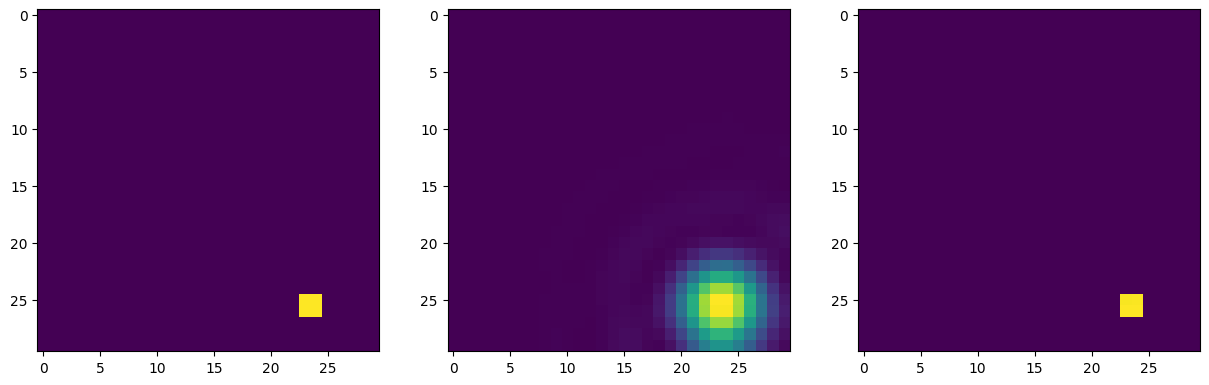

In [ ]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/boomalope/symbac/symbac/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

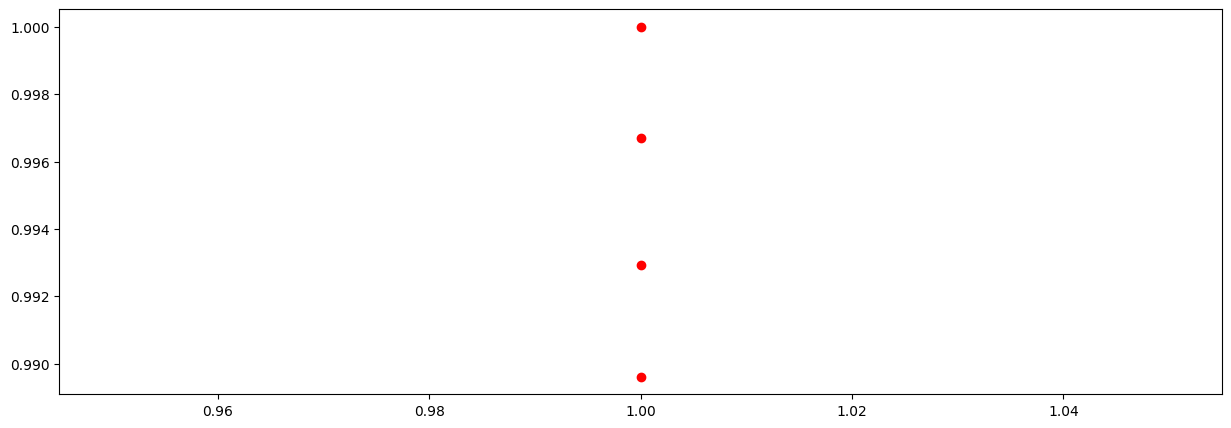

In [ ]:
original_intensity = []
custom_intensity = []

for i in range(len(modelIntensity)):
    original_intensity.append(oriNormalised[sourcePts[i][0]][sourcePts[i][1]])
    custom_intensity.append(customOriginal[sourcePts[i][0]][sourcePts[i][1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)